# 1. Introduction
# Survival analysis of ICU in-hospital mortality with Kaplan–Meier

What you will learn  
- What censoring means and why Kaplan–Meier (KM) handles it well  
- How to read survival curves, cumulative hazard, at-risk tables, and restricted mean survival time (RMST)  
- How to compare groups with log-rank tests and extract clinically useful numbers at 7, 30, and 90 days

Data and outcome  
- Time origin is ICU admission  
- Duration = hospital days until discharge or in-hospital death  
- Event = in-hospital death  
- Censoring occurs at discharge alive

Clinical lens  
- KM describes prognosis over time for a population or subgroup  
- RMST at a horizon t0 is an easy number to communicate to clinicians and families


# 2. Setup

In [1]:
# Setup and versions
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown
from utils import km_by_group

from lifelines import KaplanMeierFitter, NelsonAalenFitter
from lifelines.statistics import logrank_test, multivariate_logrank_test
from lifelines.plotting import add_at_risk_counts
from lifelines.utils import restricted_mean_survival_time, median_survival_times

import platform, sys
print(f"Python {platform.python_version()}")
print("pandas", pd.__version__, "numpy", np.__version__)
import lifelines, matplotlib
print("lifelines", lifelines.__version__, "matplotlib", matplotlib.__version__)

np.random.seed(42)


Python 3.11.13
pandas 2.3.3 numpy 2.3.3
lifelines 0.30.0 matplotlib 3.10.6


# 3. Load data and define survival variables

## Data set characteristics — PhysioNet/CinC 2012, Set A (aggregated outcomes file)

Number of instances: 4 000 ICU stays in training set A 

Number of attributes: 5 outcome-related descriptors plus a unique record identifier 


Attribute information
- RecordID: unique identifier for the ICU stay
- SAPS-I: Simplified Acute Physiology Score I, computed from early ICU measurements, higher indicates greater acuity, unitless score 

- SOFA: Sequential Organ Failure Assessment score, higher indicates greater organ dysfunction, unitless score 

- Length_of_stay: days from ICU admission to hospital discharge or in-hospital death, measured in days 

- Survival: days from ICU admission to death, observed up to 2 years after admission, measured in days; not defined if death did not occur within follow-up 

- In-hospital_death: binary outcome indicating whether the patient died during the index hospitalization (1 = died in hospital, 0 = survived to discharge) 


Analysis-ready fields you will derive in this notebook
- duration (T): observation time used for survival analysis; for in-hospital analyses we set duration = Length_of_stay in days
- event (E): event indicator for in-hospital mortality; we set event = In-hospital_death (1 = event occurred, 0 = censored at discharge)

### Interpret and validate outcome fields

We use the [PhysioNet Challenge 2012 dataset](https://physionet.org/content/challenge-2012/1.0.0/) definitions for the aggregated outcomes file

- **Length_of_stay**: days from ICU admission until hospital discharge or in-hospital death  
- **Survival**: days from ICU admission until death; set to −1 if no death was recorded during follow-up  
- **In-hospital_death**: 1 if the patient died in the hospital, 0 otherwise

Consistency logic for this dataset  
- If `Survival > Length_of_stay`, the patient survived to hospital discharge  
- If `Survival = −1`, the patient survived to discharge or death was unobserved  
- If `Survival` is between 2 and `Length_of_stay` inclusive, the patient died in-hospital

In [2]:
PATH = "PhysionetChallenge2012-set-a.csv.gz"
ICU = pd.read_csv(PATH, compression="gzip")

# Clean obvious negative sentinels for non-time variables
for col in ["Height", "Weight"]:
    if col in ICU.columns:
        ICU.loc[ICU[col] < 0, col] = np.nan

# Keep rows with both Length_of_stay and In-hospital_death present
valid = ICU["Length_of_stay"].notna() & ICU["In-hospital_death"].notna()
ICU = ICU.loc[valid].copy()

# KM for in-hospital mortality
ICU["duration"] = ICU["Length_of_stay"].clip(lower=0).astype(float)   # time from ICU admission to discharge or in-hospital death
ICU["event"] = ICU["In-hospital_death"].astype(int)                   # 1 = died in hospital, 0 = discharged alive

ICU.head()

,recordid,SAPS-I,SOFA,Length_of_stay,Survival,In-hospital_death,Age,Gender,Height,Weight,...,TroponinT_last,WBC_last,Weight_last,pH_last,MechVentStartTime,MechVentDuration,MechVentLast8Hour,UrineOutputSum,duration,event
0,132539,6,1,5,-1,0,54.0,0.0,NaN,NaN,...,NaN,9.4,NaN,NaN,NaN,NaN,NaN,NaN,5.0,0
1,132540,16,8,8,-1,0,76.0,1.0,175.3,76.0,...,NaN,13.3,81.6,7.37,71.0,360.0,0.0,5.0,8.0,0
2,132541,21,11,19,-1,0,44.0,0.0,NaN,56.7,...,NaN,6.2,56.7,7.47,617.0,2160.0,1.0,14.0,19.0,0
3,132543,7,1,9,575,0,68.0,1.0,180.3,84.6,...,NaN,7.9,84.6,NaN,NaN,NaN,NaN,NaN,9.0,0
4,132545,17,2,4,918,0,88.0,0.0,NaN,NaN,...,NaN,4.8,NaN,NaN,NaN,NaN,NaN,NaN,4.0,0


In [3]:
ICU[['Survival', 'Length_of_stay', 'In-hospital_death']].sample(10)

,Survival,Length_of_stay,In-hospital_death
555,-1,16,0
3491,159,32,0
527,4,4,1
3925,13,14,1
2989,1444,23,0
70,15,16,1
1756,-1,12,0
211,-1,11,0
196,1353,11,0
803,628,12,0


### Exploratory data analysis for ICU survival dataset

- Verify the event and censoring structure before modeling  
- Understand distributions of time variables, severity scores, and demographics  
- Spot missingness or outliers that could bias Kaplan–Meier and Cox models

Checking for:
- Cohort size, event rate, censoring rate, and quick time sanity checks  
- Distributions of Length_of_stay and Survival including the −1 code  
- Severity and demographic distributions and how they differ by event  
- Missingness per variable to guide simple imputation choices


In [4]:
# Cohort briefing table with clear labels and units

n_patients = len(ICU)
events_provided = int(ICU["event"].sum())
event_rate = ICU["event"].mean()
censor_rate = 1.0 - event_rate

# Length of stay (LOS) summaries
los_median = float(ICU["duration"].median())
los_q1, los_q3 = float(ICU["duration"].quantile(0.25)), float(ICU["duration"].quantile(0.75))
los_min, los_max = float(ICU["duration"].min()), float(ICU["duration"].max())

# Raw LOS min to flag anomalies if any
los_min_raw = float(ICU["Length_of_stay"].min())

# Survival code summaries
has_surv = "Survival" in ICU.columns
surv_eq_minus1 = int((ICU["Survival"] == -1).sum()) if has_surv else None
surv_gt_los = int((ICU["Survival"] > ICU["Length_of_stay"]).sum()) if has_surv else None
surv_le_los_nonneg = int(((ICU["Survival"] >= 0) & (ICU["Survival"] <= ICU["Length_of_stay"])).sum()) if has_surv else None

# Also compute strict and general inferred deaths for teaching
inferred_strict = int(((ICU["Survival"] >= 2) & (ICU["Survival"] <= ICU["Length_of_stay"])).sum()) if has_surv else None
inferred_general = surv_le_los_nonneg

# "Clipped" - means LOS >= 0 because negative LOS would be nonsensical
rows = [
    {"Metric": "Patients", "Value": f"{n_patients:d}", "Meaning": "unique ICU stays"},
    {"Metric": "Deaths (provided)", "Value": f"{events_provided:d}", "Meaning": "in-hospital deaths from In-hospital_death"},
    {"Metric": "Event rate", "Value": f"{event_rate:.1%}", "Meaning": "fraction who died in hospital"},
    {"Metric": "Censoring rate", "Value": f"{censor_rate:.1%}", "Meaning": "fraction discharged alive"},
    {"Metric": "LOS median [IQR]", "Value": f"{los_median:.1f} d [{los_q1:.1f}, {los_q3:.1f}]",
     "Meaning": "hospital days until discharge or in-hospital death"},
    {"Metric": "LOS range (clipped)", "Value": f"{los_min:.1f} to {los_max:.1f} d", "Meaning": "range after clipping LOS to ≥ 0"},
]

# Add raw LOS min only if it is negative to explain anomalies
if los_min_raw < 0:
    rows.append({"Metric": "LOS min (raw)", "Value": f"{los_min_raw:.1f} d", "Meaning": "raw minimum before clipping; negative suggests data artifact"})

if has_surv:
    rows.extend([
        {"Metric": "Survival = −1", "Value": f"{surv_eq_minus1:d}", "Meaning": "no death recorded in follow-up, treated as censored"},
        {"Metric": "Survival > LOS", "Value": f"{surv_gt_los:d}", "Meaning": "survived beyond discharge, censored at discharge"},
        {"Metric": "Deaths inferred (general)", "Value": f"{inferred_general:d}", "Meaning": "0–LOS days counted as in-hospital death"},
        {"Metric": "Deaths inferred (strict)", "Value": f"{inferred_strict:d}", "Meaning": "2–LOS days counted as in-hospital death"},
    ])

brief = pd.DataFrame(rows, columns=["Metric","Value","Meaning"])
display(brief)


,Metric,Value,Meaning
0,Patients,4000,unique ICU stays
1,Deaths (provided),554,in-hospital deaths from In-hospital_death
2,Event rate,13.9%,fraction who died in hospital
3,Censoring rate,86.1%,fraction discharged alive
4,LOS median [IQR],"10.0 d [6.0, 17.0]",hospital days until discharge or in-hospital d...
5,LOS range (clipped),0.0 to 154.0 d,range after clipping LOS to ≥ 0
6,LOS min (raw),-1.0 d,raw minimum before clipping; negative suggests...
7,Survival = −1,2526,"no death recorded in follow-up, treated as cen..."
8,Survival > LOS,919,"survived beyond discharge, censored at discharge"
9,Deaths inferred (general),555,0–LOS days counted as in-hospital death


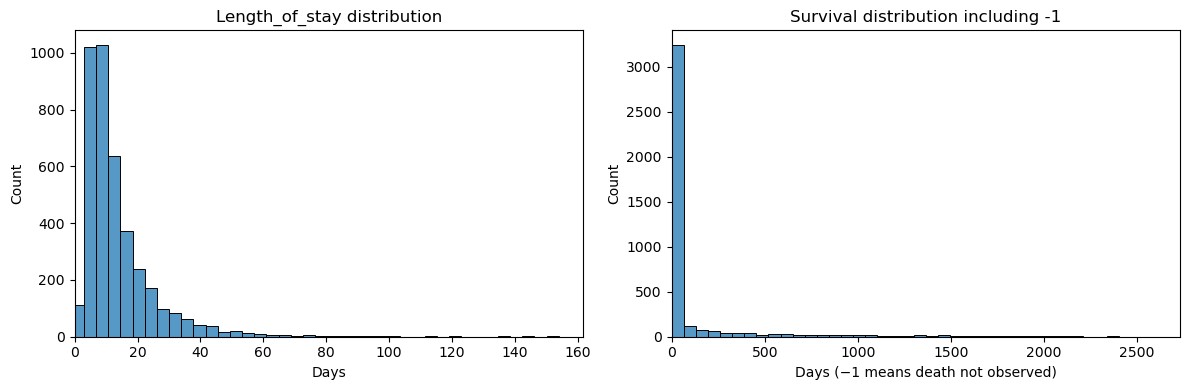

In [5]:
# Visualize time scales and confirm focus windows students will use later
fig, axes = plt.subplots(1, 2, figsize=(12,4), sharey=False)

# Length_of_stay distribution
sns.histplot(ICU["Length_of_stay"], bins=40, ax=axes[0])
axes[0].set_title("Length_of_stay distribution")
axes[0].set_xlabel("Days")
axes[0].set_ylabel("Count")
axes[0].set_xlim(left=0)

# Survival distribution, keeping -1 visible
if "Survival" in ICU.columns:
    sns.histplot(ICU["Survival"], bins=40, ax=axes[1])
    axes[1].set_title("Survival distribution including -1")
    axes[1].set_xlabel("Days (−1 means death not observed)")
    axes[1].set_xlim(left=-1)

plt.tight_layout()


- Censoring is dominant: most patients are censored because they leave the hospital alive or survive past follow-up. That’s why Kaplan–Meier is essential
- Most events are early: the hazard is front-loaded — early ICU days carry much higher risk
- Long tails matter: a handful of extreme stays and very long survivals exist. They won’t change the median but they inflate variance later. This explains why KM confidence intervals get wide after 30–90 days
- When interpreting survival curves, emphasize early vs late hazards. For ICU, survival within the first 30 days is often the most actionable metric

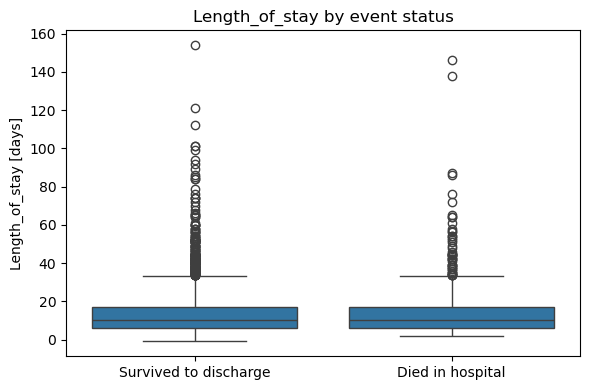

In [6]:
# Check if hospital days differ between decedents and survivors

import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6,4))
sns.boxplot(
    data=ICU.assign(event_label=ICU["event"].map({0:"Survived to discharge", 1:"Died in hospital"})),
    x="event_label",
    y="Length_of_stay",
    ax=ax
)
ax.set_xlabel("")
ax.set_ylabel("Length_of_stay [days]")
ax.set_title("Length_of_stay by event status")
plt.tight_layout()


- Lenght Of Stay (LOS) is not a strong discriminator of outcome. Patients who die in the hospital don’t necessarily stay longer or shorter than those who survive to discharge
- Simply knowing “how long a patient has been in hospital” doesn’t predict mortality well in this cohort
- Early severity scores e.g. SAPS-I, SOFA, and physiological measures are more informative for survival modeling
- This is why Cox and RSF need covariates beyond LOS

KM can stratify by LOS after the fact, but LOS itself is not a predictor we can use at admission (it’s only known retrospectively)

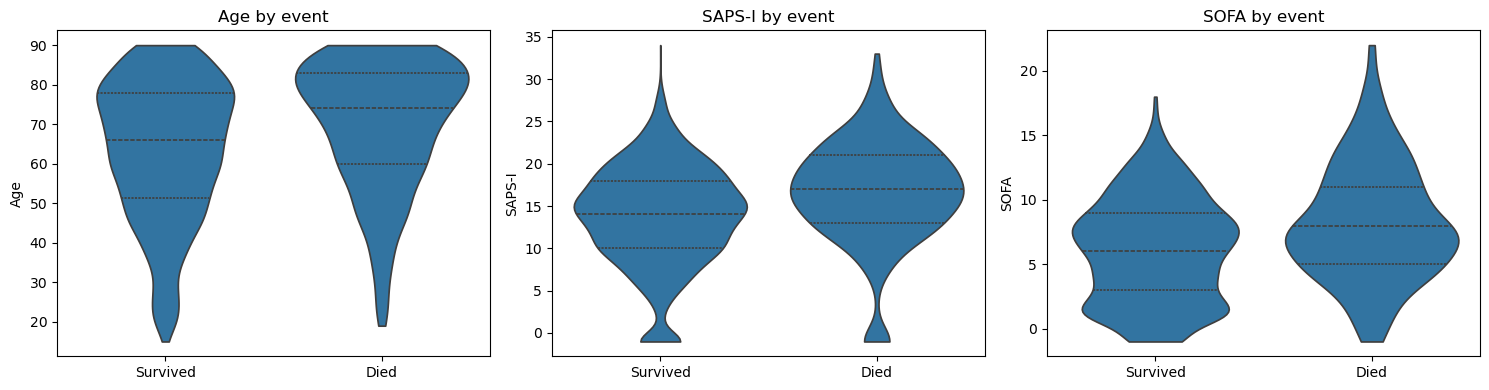

In [7]:
# Quick clinical sense check of important covariates
# Severity and age plots by event should show higher acuity among decedents, if not, revisit variable definitions


import seaborn as sns
import matplotlib.pyplot as plt

plot_vars = [c for c in ["Age","SAPS-I","SOFA"] if c in ICU.columns]
n = len(plot_vars)
if n > 0:
    fig, axes = plt.subplots(1, n, figsize=(5*n,4))
    if n == 1:
        axes = [axes]
    for ax, col in zip(axes, plot_vars):
        sns.violinplot(
            data=ICU.assign(event_label=ICU["event"].map({0:"Survived", 1:"Died"})),
            x="event_label", y=col, cut=0, inner="quartile", ax=ax
        )
        ax.set_xlabel("")
        ax.set_title(f"{col} by event")
    plt.tight_layout()
else:
    print("No severity or age columns found to plot")


- Unlike LOS, these baseline covariates clearly separate survivors and non-survivors
- They provide the clinical rationale for including Age, SAPS-I, and SOFA in Cox or RSF models

# 3. KM (Kaplan–Meier) survival curve - overall

- KM estimates the survival function S(t) while correctly handling right censoring  
- The curve answers questions like what proportion of patients are alive at 7, 30, 90 days

Reading the plot:  
- Steep early drops indicate high early hazard  
- Confidence bands widen when fewer patients remain at risk

In [8]:
# Fit and plot overall KM with at-risk counts
kmf = KaplanMeierFitter(label="All patients")
kmf.fit(ICU["duration"], event_observed=ICU["event"])
# Displaying the survival function
kmf.survival_function_


,All patients
timeline,
0.0,1.000000
1.0,1.000000
2.0,0.994923
3.0,0.985457
4.0,0.973606
...,...
112.0,0.341080
121.0,0.341080
138.0,0.227387


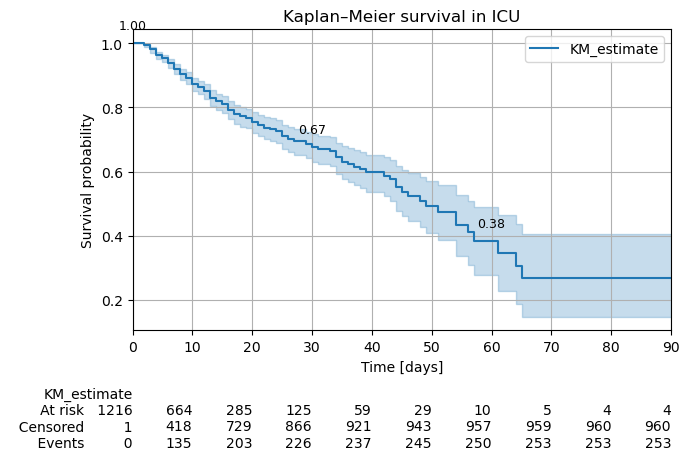

In [26]:
fig, ax = plt.subplots(figsize=(7,5))

# Survival curve
kmf.plot_survival_function(ax=ax)
ax.set_title("Kaplan–Meier survival in ICU")
ax.set_xlabel("Time [days]")
ax.set_ylabel("Survival probability")

# Add gridlines
ax.grid(True)

# Zoom in to first 90 days for clarity
ax.set_xlim(0, 90)

# Annotate specific time points (0, 30, 60 days if present)
for t in [0, 30, 60]:
    if t in kmf.survival_function_.index:
        y = kmf.survival_function_.loc[t].values[0]
        ax.annotate(f"{y:.2f}",
                    xy=(t, y),
                    xytext=(0, 10),
                    textcoords="offset points",
                    ha='center',
                    fontsize=9,
                    color="black")

# Add risk table beneath the plot
add_at_risk_counts(kmf, ax=ax)

plt.tight_layout()
plt.show()

**Plor description**
1. Early steep decline
    - The curve drops sharply in the first 20–30 days. Meaning in-hospital mortality risk is concentrated early after ICU admission
    - “What is the probability of *surviving in hospital* by time t among everyone who started at t = 0”
2. Progressive decline
    - By day 30, survival probability is around 70%, by day 90, survival probability drops to ~40%
    - Among patients still hospitalized, mortality risk continues to accumulate
3. Widening confidence intervals
    - After 60–70 days, the shaded band widens. Reflecting that very few patients are still at risk — estimates are less precise

**At Risk Table**
At risk: how many patients were still in hospital at each time point
Censored: how many patients were discharged alive by that time
Events: how many deaths occurred by that time

**Clinical insights**

1. Mortality risk is front-loaded but persistent
    - The curve drops most rapidly in the first 30 days → early ICU phase is highest risk
    - After that, the slope flattens, meaning the conditional risk decreases for those who survive longer

2. Most patients leave alive (censored)
    - The table shows that by 30 days, over 3,100 patients have been discharged alive (“censored”), while only ~500 deaths have occurred
    - This reinforces that discharge is the dominant outcome, and KM accounts for it by censoring

3. Uncertainty grows with time
    - After ~60 days, few patients remain in hospital (see “At risk” row), so the shaded CI widens
    - These later estimates should be interpreted with caution because they rely on very small denominators

4. Actionable horizons
    - 30-day survival ≈ 71% is a clear, clinically interpretable metric often reported in critical care studies
    - 60-day survival ≈ 49% shows how much risk accumulates for long-stay patients

In [10]:
# Quantify survival at decision-friendly horizons
for t in [7, 30, 90]:
    s = float(kmf.survival_function_at_times(t).values)
    print(f"S({t} d) = {s:.3f}")


S(7 d) = 0.942
S(30 d) = 0.713
S(90 d) = 0.341


## 3.1. Median Survival Time
The **median survival time** is the time point at which the survival probability first drops to 50% or below. This metric provides a single, intuitive summary of the typical survival duration

i.e. The median survival time is the point in time when 50% of the patients have died (the survival probability S(t) drops to 0.5)

In [11]:
# Calculate and print the median survival time
median_survival_time = kmf.median_survival_time_
print(f"The median survival time for the ICU cohort is: {median_survival_time:.1f} days")

The median survival time for the ICU cohort is: 58.0 days


## 3.2. Restricted mean survival time (RMST)

- RMST is the average number of days a patient is alive within a chosen time window
- _“If we follow everyone for at most "t0" (cut-off) days, how many days alive do we expect on average?”_
- One number clinicians can discuss even when the median survival is not reached

**Why and when is used?**
- Sometimes the median survival is not reached because more than half the patients are still alive at the end of follow-up. Then the median can’t be computed
- RMST always exists. It gives a single, easy-to-interpret number that clinicians can discuss

Example: RMST to 90 days = 65 days → “On average, patients survive 65 of the first 90 days after ICU admission.”


In [12]:
# Overall RMST (no subgrouping)
# Fit KM on the whole cohort (ensure non-negative times)
km_overall = KaplanMeierFitter(label="All patients").fit(
    ICU["duration"].clip(lower=0), ICU["event"]
)

# Pick one horizon (t0) or several
horizons = [30.0, 60.0, 90.0]

rows = []
for t0 in horizons:
    rmst_val = restricted_mean_survival_time(km_overall, t=t0)
    rows.append({"t0 [days]": int(t0), "RMST [days]": round(float(rmst_val), 1)})

rmst_table = pd.DataFrame(rows)
display(rmst_table)


,t0 [days],RMST [days]
0,30,25.9
1,60,43.9
2,90,56.5


## Survival views to read risk from different angles

What each plot tells you  
- Kaplan–Meier survival S(t): probability of not dying in hospital by day t  
- Nelson–Aalen cumulative hazard H(t): how quickly risk accumulates over time  
- Cumulative incidence curves: probability by day t of death in hospital vs discharge alive

How to use them together  
- KM shows overall survival level at clinically relevant horizons such as 7, 30, 90 days  
- Nelson–Aalen highlights when risk is concentrated by looking at where the curve is steepest  
- Cumulative incidence separates the two outcomes so you can see which becomes more likely over time


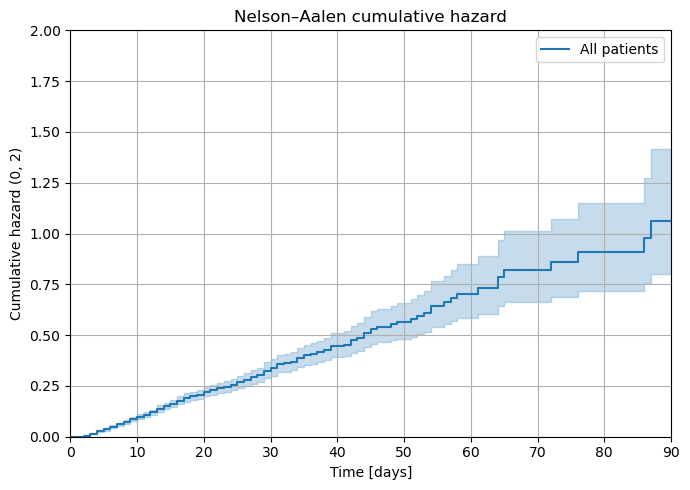

In [25]:
# Nelson–Aalen cumulative hazard to show when risk accumulates fastest
naf = NelsonAalenFitter(label="All patients")
naf.fit(ICU["duration"], ICU["event"])

fig, ax = plt.subplots(figsize=(7,5))
naf.plot_cumulative_hazard(ax=ax)
ax.set_title("Nelson–Aalen cumulative hazard")
ax.set_xlabel("Time [days]")
ax.set_ylabel("Cumulative hazard (0, 2)")
ax.grid(True)
ax.set_xlim(0, 90)
ax.set_ylim(0, 2)
plt.tight_layout()
plt.show()


**Clinical Insights**

1. Early linear growth
    - From day 0 to ~30, the hazard increases almost linearly, reflecting a relatively steady risk of in-hospital death in the early weeks

2. Flattening after ~30 days
    - After day 30, the slope is less steep. That means conditional risk of death decreases once patients survive past the acute phase
    - This aligns with the KM plot: survivors after the first month are more likely to leave alive

3. Cumulative hazard reaching ~1 by 90 days
    - A cumulative hazard of 1 at 90 days means the “average” patient experiences roughly one expected event over that time
    - In practice, this is a population-level summary: it does not mean every patient dies, but that the risk accumulation across all patients sums to one “death equivalent”

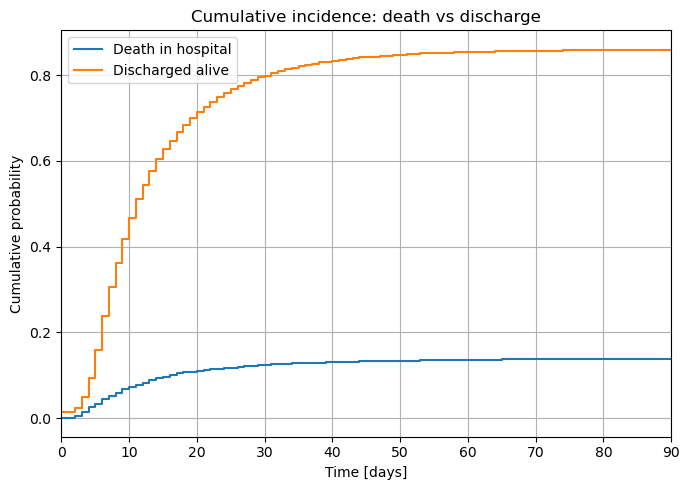

In [27]:
# Ensure non-negative times
time = ICU["duration"].clip(lower=0).to_numpy()
event_type = np.where(ICU["event"].astype(int) == 1, 1, 2).astype(int)

from sksurv.nonparametric import cumulative_incidence_competing_risks
import matplotlib.pyplot as plt

# Run CIF
times, cif_estimates = cumulative_incidence_competing_risks(
    event=event_type,
    time_exit=time,
    conf_type=None  # Only two outputs: times, estimates
)

plt.figure(figsize=(7,5))
for ev_code, label in [(1, "Death in hospital"), (2, "Discharged alive")]:
    plt.step(times, cif_estimates[ev_code], where="post", label=label)

plt.xlim(0, 90)
plt.xlabel("Time [days]")
plt.ylabel("Cumulative probability")
plt.title("Cumulative incidence: death vs discharge")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


**Clinical insights**

1. Early separation of outcomes
    - Most ICU patients leave alive within the first 2–3 weeks
    - Mortality, while significant, accumulates more slowly and levels off early

2. Front-loaded risk
    - The hazard of in-hospital death is concentrated in the first weeks
    - Survivors beyond 30 days have a very high chance of leaving hospital alive rather than dying in-hospital

3. Resource planning
    - The steep early discharge means ICU bed turnover is high in the first two weeks
    - Persistent ICU patients beyond 30 days are a minority and represent a resource-intensive subgroup

4. Communication with families
    - These curves give clinicians intuitive numbers:
    - “By 30 days, about 8 out of 10 patients are discharged alive”
    - “About 1 in 7 die in the hospital, almost always within the first month”

# 4. Subgroup comparisons with log-rank tests

WHY this step  
- We test whether entire survival trajectories differ between groups  
- Use clinically meaningful covariates such as sex, severity tertiles, or age bands

Interpretation  
- Low p-value suggests curves differ somewhere over time  
- Check the plot to see when differences emerge


In [15]:
# Why: a quick glance at variables students will use for subgroup KM
candidates = ["Age","Gender","ICUType","SAPS-I","SOFA","Length_of_stay","Survival"]
cols = [c for c in candidates if c in ICU.columns] + ["duration","event"]

display(ICU[cols].head(8))
display(ICU[cols].isna().mean().sort_values(ascending=False).to_frame("missing_rate"))
print("Event rate =", ICU["event"].mean())


,Age,Gender,SAPS-I,SOFA,Length_of_stay,Survival,duration,event
0,54.0,0.0,6,1,5,-1,5.0,0
1,76.0,1.0,16,8,8,-1,8.0,0
2,44.0,0.0,21,11,19,-1,19.0,0
3,68.0,1.0,7,1,9,575,9.0,0
4,88.0,0.0,17,2,4,918,4.0,0
5,64.0,1.0,14,11,6,1637,6.0,0
6,68.0,0.0,14,4,9,-1,9.0,0
7,78.0,0.0,19,8,6,5,6.0,1


,missing_rate
Gender,0.00075
Age,0.00000
SAPS-I,0.00000
SOFA,0.00000
Length_of_stay,0.00000
Survival,0.00000
duration,0.00000
event,0.00000


Event rate = 0.1385


Log-rank p-value (Female vs Male): 0.2542350238240646


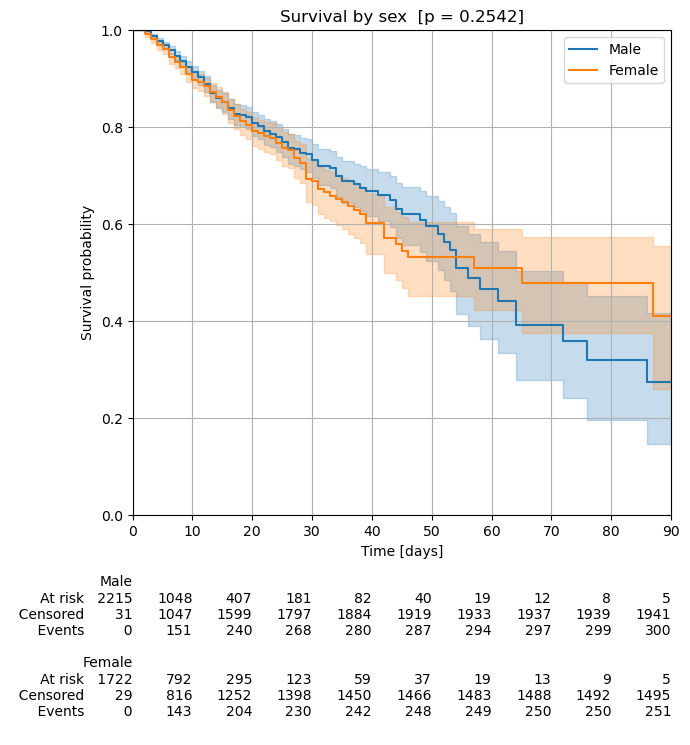

In [16]:
# Sex differences if available
if "Gender" in ICU.columns:
    label_map = {0: "Female", 1: "Male"}
    km_by_group(ICU, "Gender", title="Survival by sex", label_map=label_map)

    g0 = ICU.loc[ICU["Gender"] == 0]  # Female
    g1 = ICU.loc[ICU["Gender"] == 1]  # Male
    if len(g0) > 5 and len(g1) > 5:
        res = logrank_test(
            g0["duration"], g1["duration"],
            event_observed_A=g0["event"],
            event_observed_B=g1["event"]
        )
        print("Log-rank p-value (Female vs Male):", res.p_value)


Multigroup log-rank p-value for SAPS-I tertiles: 1.0113465695717364e-06


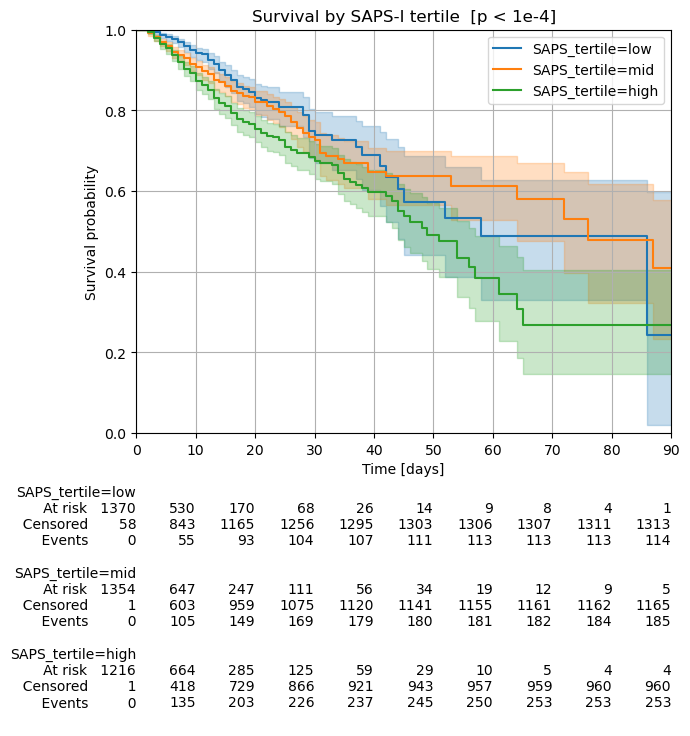

In [17]:
# Illness severity via SAPS-I tertiles if available
if "SAPS-I" in ICU.columns:
    ICU["SAPS_tertile"] = pd.qcut(ICU["SAPS-I"], q=3, labels=["low","mid","high"])
    km_by_group(ICU, "SAPS_tertile", title="Survival by SAPS-I tertile")
    res_saps = multivariate_logrank_test(ICU["duration"], groups=ICU["SAPS_tertile"], event_observed=ICU["event"])
    print("Multigroup log-rank p-value for SAPS-I tertiles:", res_saps.p_value)


In [18]:
t0 = 90.0
rmst_overall = restricted_mean_survival_time(kmf, t=t0)
print(f"RMST to {t0:.0f} days overall: {rmst_overall:.1f} days")

if "SAPS_tertile" in ICU.columns:
    for lvl in ["low","mid","high"]:
        dfg = ICU.loc[ICU["SAPS_tertile"] == lvl]
        if len(dfg) > 20:
            km = KaplanMeierFitter().fit(dfg["duration"], dfg["event"])
            rmst_g = restricted_mean_survival_time(km, t=t0)
            print(f"RMST to {t0:.0f} days, SAPS-I {lvl}: {rmst_g:.1f} days")


RMST to 90 days overall: 56.5 days
RMST to 90 days, SAPS-I low: 59.1 days
RMST to 90 days, SAPS-I mid: 61.2 days
RMST to 90 days, SAPS-I high: 49.5 days


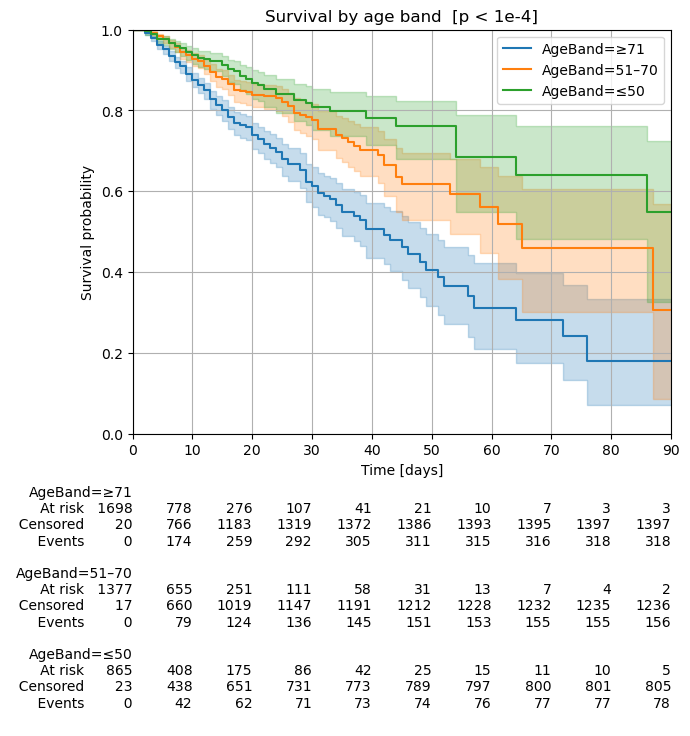

In [19]:
# Age bands if available
if "Age" in ICU.columns:
    ICU["AgeBand"] = pd.cut(ICU["Age"], bins=[0, 50, 70, 200], labels=["≤50","51–70","≥71"], right=True)
    km_by_group(ICU, "AgeBand", title="Survival by age band")


# 5. Bridge to Cox: does the proportional hazards idea look reasonable?

The **Cox Proportional Hazards (CPH)** model, which we will use in the next notebook, assumes that the **hazard ratio between groups stays constant over time**.  This is called the *proportional hazards assumption*.

### Why check this?
- CPH gives us hazard ratios, which are easy to interpret if they are stable
- If the relative risk between groups changes over time, those hazard ratios can be misleading

### Log-minus-log survival plots
- We plot `log(-log(S(t)))` against `log(time)` for each group 
- If the curves are roughly **parallel**, the proportional hazards assumption looks plausible
- If the curves **cross** or diverge strongly, the assumption may not hold

### What happens if proportionality looks weak?
- **Formally test** proportional hazards with Schoenfeld residuals
- Use **stratification** (different baselines for certain groups) or **time-varying effects** when needed
- Compare **restricted mean survival time (RMST)** and **time-dependent C-index** to make sure conclusions are robust

### Clinical insights
- **Parallel curves**: risk differences between groups stay stable → hazard ratios are reliable, easy to communicate
- **Non-parallel curves**: risk differences change over time → interpretation must be more careful, and we may need more flexible models

The **log-minus-log** plot is a *bridge* between the Kaplan–Meier world and Cox modeling, showing us whether the idea of a constant hazard ratio is even reasonable before we trust Cox results


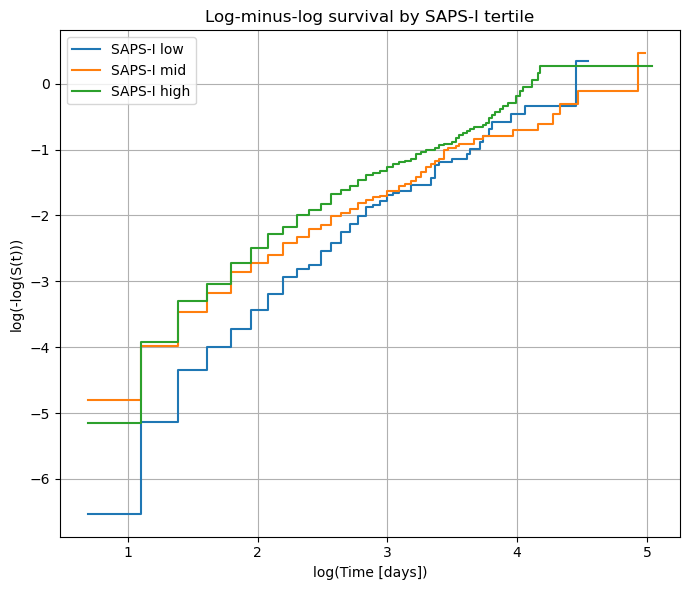

Gap high−low at 15 d: 0.575
Gap high−low at 45 d:  0.112
Change in gap (late − early): -0.463
Rule of thumb: small change suggests proportional hazards is reasonable
Large change suggests exploring stratification or time-varying effects in the Cox model


In [20]:
# Log-minus-log survival by SAPS-I tertiles, plus a tiny numeric check

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

# 1) Build SAPS-I tertiles if needed
if "SAPS_tertile" not in ICU.columns and "SAPS-I" in ICU.columns:
    ICU["SAPS_tertile"] = pd.qcut(ICU["SAPS-I"], q=3, labels=["low", "mid", "high"])

groups = ["low", "mid", "high"]
groups = [g for g in groups if (ICU.get("SAPS_tertile") == g).sum() >= 20]
if len(groups) < 2:
    print("Not enough SAPS-I groups with sample size ≥ 20")
else:
    fig, ax = plt.subplots(figsize=(7, 6))
    km = KaplanMeierFitter()

    # 2) Log-minus-log plot
    for g in groups:
        dfg = ICU.loc[ICU["SAPS_tertile"] == g, ["duration", "event"]].dropna()
        if len(dfg) < 20:
            continue
        km.fit(dfg["duration"].clip(lower=0), dfg["event"], label=f"SAPS-I {g}")
        km.plot_loglogs(ax=ax)  # log(-log(S)) vs time on log scale

    ax.set_title("Log-minus-log survival by SAPS-I tertile")
    ax.set_xlabel("log(Time [days])")
    ax.set_ylabel("log(-log(S(t)))")
    ax.grid(True)
    plt.tight_layout()
    plt.show()

    # 3) Tiny numeric sanity check for proportionality (didactic)
    #    Compare the gap between groups at an early and a later time
    #    If the gap changes a lot, hazards may not be proportional
    def lml_at(kmf: KaplanMeierFitter, t: float) -> float:
        s = float(kmf.predict(t))
        s = min(max(s, 1e-9), 1.0)  # guard
        return np.log(-np.log(s))

    landmarks_early = 15.0
    landmarks_late = 45.0

    # Fit once per group to read values
    fits = {}
    for g in groups:
        dfg = ICU.loc[ICU["SAPS_tertile"] == g, ["duration", "event"]].dropna()
        kmf = KaplanMeierFitter().fit(dfg["duration"].clip(lower=0), dfg["event"])
        fits[g] = {
            "lml_early": lml_at(kmf, landmarks_early),
            "lml_late":  lml_at(kmf, landmarks_late),
        }

    # Report the change in separation between high and low
    if all(k in fits for k in ["low", "high"]):
        gap_early = fits["high"]["lml_early"] - fits["low"]["lml_early"]
        gap_late  = fits["high"]["lml_late"]  - fits["low"]["lml_late"]
        delta_gap = gap_late - gap_early
        print(f"Gap high−low at {int(landmarks_early)} d: {gap_early:.3f}")
        print(f"Gap high−low at {int(landmarks_late)} d:  {gap_late:.3f}")
        print(f"Change in gap (late − early): {delta_gap:.3f}")
        print("Rule of thumb: small change suggests proportional hazards is reasonable")
        print("Large change suggests exploring stratification or time-varying effects in the Cox model")
